# CNN CIFAR-10

## Imports

In [1]:
import os

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import wandb

In [2]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")

print(mps_device)

mps


## Load Dataset

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


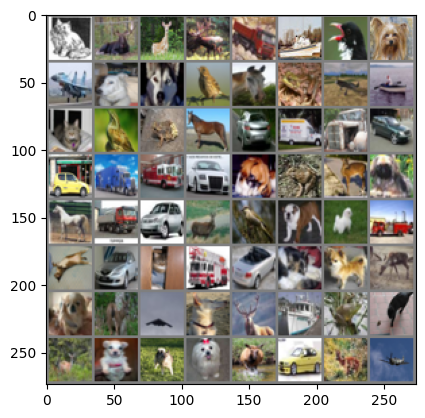

cat   deer  deer  deer  truck ship  bird  dog   plane dog   dog   bird  horse frog  plane ship  cat   bird  frog  horse car   truck truck car   car   truck truck car   dog   frog  deer  dog   horse truck car   deer  bird  dog   dog   truck cat   car   cat   truck car   cat   dog   deer  dog   deer  plane dog   deer  ship  frog  cat   deer  dog   dog   dog   deer  car   deer  plane


In [4]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## CNN Model

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(mps_device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Loss Function and Optimizer

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Metrics

In [7]:
def calculate_accuracy(net, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data

            # move batch to GPU
            images = images.to(mps_device)
            labels = labels.to(mps_device)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

### Training the Model

In [8]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'mini-challenge-1.ipynb'

# Setup Weight & Biases
wandb.init(
    # set the wandb project where this run will be logged
    entity='yvokeller',
    project='deep-learning',
    # track hyperparameters and run metadata
    config={
        'learning_rate': 0.02,
        'architecture': 'CNN',
        'dataset': 'CIFAR-10',
        'epochs': 2,
    }
)

wandb: Currently logged in as: yvokeller. Use `wandb login --relogin` to force relogin


In [9]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # move batch to GPU
        inputs = inputs.to(mps_device)
        labels = labels.to(mps_device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

            train_accuracy = calculate_accuracy(net, trainloader)
            test_accuracy = calculate_accuracy(net, testloader)
            print(f'Train accuracy: {train_accuracy:.2f}%')
            print(f'Val accuracy: {test_accuracy:.2f}%')

            wandb.log({'loss': loss, 'train_acc': train_accuracy, 'test_acc': test_accuracy})

wandb.finish()
print('Finished Training')

Finished Training


In [10]:
MODEL_PATH = './cifar_net.pth'
torch.save(net.state_dict(), MODEL_PATH)

### Testing the Model

#### Ground Truth

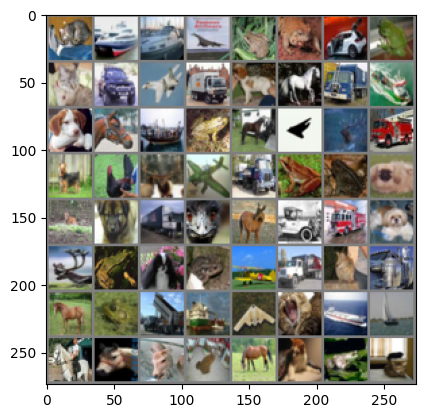

GroundTruth:  cat   ship  ship  plane


In [11]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

#### Model Prediction

In [12]:
net = Net()
net.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [13]:
# Predict
outputs = net(images)
outputs

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   ship  ship  ship 
